In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FixedLocator, NullLocator
import time
from matplotlib.gridspec import GridSpec

In [2]:
def step_mat(K,dt):
    if K<0:
        return np.array([[np.cosh(dt*np.sqrt(-K)),np.sqrt(-K)*np.sinh(dt*np.sqrt(-K))],[1/np.sqrt(-K)*np.sinh(dt*np.sqrt(-K)),np.cosh(dt*np.sqrt(-K))]])
    if K==0:
        return np.array([[1,0],[dt,1]])
    if K>0:
        return np.array([[np.cos(dt*np.sqrt(K)),-np.sqrt(K)*np.sin(dt*np.sqrt(K))],[1/np.sqrt(K)*np.sin(dt*np.sqrt(K)),np.cos(dt*np.sqrt(K))]])

def arg(z):
    ans = np.arctan2(z[1],z[0])
    if ans<0:
        return ans+2*np.pi
    else:
        return ans
    
def new_arg(old_arg, K, dt):
    old_z = [np.cos(old_arg), np.sin(old_arg)]
    new_z = old_z @ step_mat(K, dt)
    return arg(new_z)

def new_sost(DP, old_sost, K, dt):
    oarg = np.pi / DP * (1 + 2 * old_sost)
    narg = new_arg(oarg, K, dt)
    return int(np.floor(narg * DP / 2 / np.pi))

Наше базовое уравнение - уравнение Якоби: $y''+Ky=0$. Домножим его на $2y'$. Получим $2y'y''+2Kyy' = 0$, то есть $\frac{d}{dx}\left((y')^2+Ky^2\right) = 0$. Получили первый интеграл уравнения, равный $(y')^2+Ky^2$ (отметим, это выражение сохраняется только на том отрезке, на котором $K\equiv K$).

Отметим интересный смысл этого выражения. Введём вектор $\vec{z} = \left(y, y'\right)^{T}$. Тогда $\|\frac{d\vec{z}}{dx}\| = \|\frac{d}{dx}(y,y')^{T} \| = \|(y',y'')^{T} \| = \|(y',-Ky)^{T}\| = \sqrt{(y')^2+Ky^2}$, то есть первый интеграл нашего уравнения есть квадрат скорости движения по фазовой плоскости.

Уравнение $(y')^2 + Ky^2 = C$ задаёт эллипсы, гиперболы или прямые $y = a$ в зависимости от знака $K$.

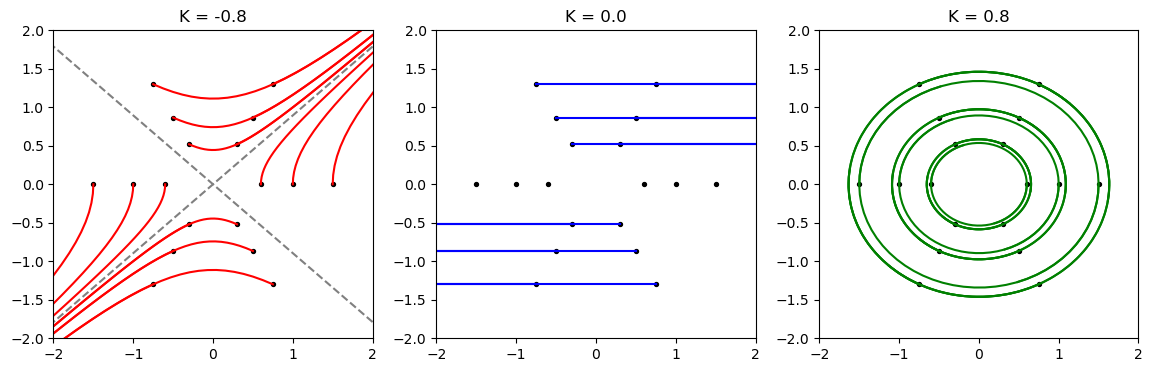

In [3]:
lim = 2
K_set = [-0.8,0.0,0.8]
radiuses = [0.6,1,1.5]
razb = 6
start_points = np.array([[r*np.cos(phi),r*np.sin(phi)] for r in radiuses for phi in np.linspace(0,2*(1-1/razb)*np.pi,razb)])
steps_num = 50
steps_len = 5/steps_num
Z = np.zeros((steps_num, 2))

fig = plt.figure(figsize = (14,4))

ax1 = plt.subplot(1,3,1)
ax1.set(xlim = (-lim, lim),ylim = (-lim, lim))
ax1.scatter(start_points.T[0],start_points.T[1], c = 'black', s = 8)
K = K_set[0]
B = step_mat(K, steps_len)
for start_point in start_points:
    Z[0] = start_point
    for i in range(steps_num)[1:]:
        Z[i] = Z[i-1] @ B
    ax1.plot(Z.T[0],Z.T[1], c = 'r')
ax1.plot([-10,10],[-10*np.sqrt(-K),10*np.sqrt(-K)],ls = '--', c = 'grey')
ax1.plot([-10,10],[10*np.sqrt(-K),-10*np.sqrt(-K)],ls = '--', c = 'grey')
ax1.title.set_text(f'K = {K}')
    
ax2 = plt.subplot(1,3,2)
ax2.set(xlim = (-lim, lim),ylim = (-lim, lim))
ax2.scatter(start_points.T[0],start_points.T[1], c = 'black', s = 8)
K = K_set[1]
B = step_mat(K, steps_len)
for start_point in start_points:
    Z[0] = start_point
    for i in range(steps_num)[1:]:
        Z[i] = Z[i-1] @ B
    ax2.plot(Z.T[0],Z.T[1], c = 'b')
ax2.title.set_text(f'K = {K}')

ax3 = plt.subplot(1,3,3)
ax3.set(xlim = (-lim, lim),ylim = (-lim, lim))
ax3.scatter(start_points.T[0],start_points.T[1], c = 'black', s = 8)
K = K_set[2]
B = step_mat(K, steps_len)
for start_point in start_points:
    Z[0] = start_point
    for i in range(steps_num)[1:]:
        Z[i] = Z[i-1] @ B
    ax3.plot(Z.T[0],Z.T[1], c = 'g')
ax3.title.set_text(f'K = {K}')

plt.show()

Выше введённый вектор $\vec{z}$ меняется во времени по закону $\vec{z}(x+\Delta x) = B(K,\Delta x)\vec{z}(x)$, $B$ - матрица.
$b_{11}=b_{22} = \cos{\sqrt{K}\Delta x}, b_{12} = \frac{1}{\sqrt{K}}\sin{\sqrt{K}\Delta x}, b_{21} = -\sqrt{K}\sin{\sqrt{K}\Delta x}$

Отметим, что ассимптоты гипербол в случае $K<0$ имеют вид $y = \pm\sqrt{-K}x$. Притяжение всегда идёт к той, которая с плюсом, потому что вектора $(1,\pm\sqrt{-K}\Delta x)^T$ - собственные с собственными числами $e^{\pm\sqrt{-K}\Delta x}$

Нас интересовал вопрос о том, когда на графике величины $\ln\|(y,\varepsilon y')\|$ происходят резкие провалы. Понятно, что это происходит в тех местах, где $y=0$. Посмотрим, как поведение функции $y$ отображается на графиках $\ln\|(y,\varepsilon y')\|$ и в фазовой плоскости.

In [11]:
M = 50
N = 100
MN = M*N
z = np.zeros((MN+1,2))
PHI = np.zeros(M+1)
K_mem = np.zeros(M+1)
z[0] = [0,1]
PHI[0] = arg([z[0,1],z[0,0]])
Kmin = -1
Kmax = 1

for i in range(MN+1)[1:]:
    if i%N==0 or i==1:
        K = np.random.uniform(Kmin,Kmax)
        K_mem[int(i/N)] = K
        B = step_mat(K,1/N)
    z[i] = z[i-1] @ B
    if i%N==0:
        PHI[int(i/N)] = arg([z[i,1],z[i,0]])

for i in range(MN+1):
    z[i,1] *= 1/100

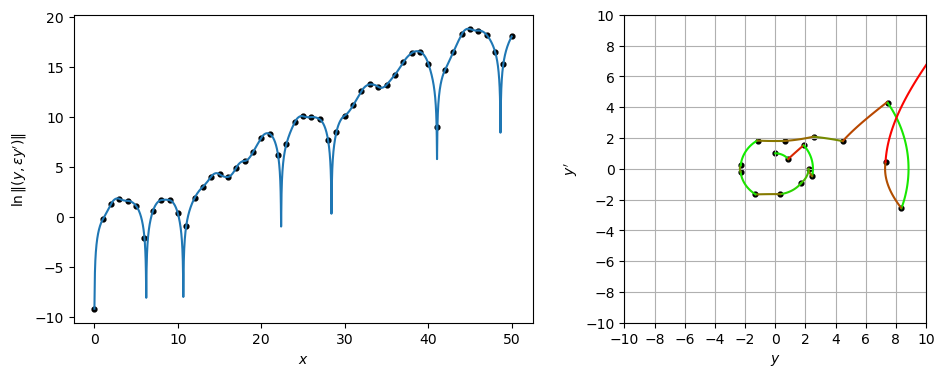

In [15]:
lim = 10

fig = plt.figure(figsize=(11,4))
gs = GridSpec(ncols=11,nrows=4,figure=fig)
ax1 = plt.subplot(gs[:,0:6])
ax2 = plt.subplot(gs[:,7:11])

X = np.linspace(0,M,MN+1)
Y = z.T[0]
Y1 = z.T[1]
Z = np.log(Y*Y+Y1*Y1)
ax1.plot(X,Z)
ax1.scatter(X[::N],Z[::N],s=12,c='black')
ax1.set_xlabel('$x$')
ax1.set_ylabel("$\ln\|(y, \epsilon y')\|$")

mm = M
ax2.set(xlim = (-lim,lim),ylim=(-lim,lim))
ax2.grid()
for m in range(mm):
    plt.plot(z[m*N:(m+1)*N,0],100*z[m*N:(m+1)*N,1],c=((K_mem[m]-Kmax)/(Kmin-Kmax),(Kmin-K_mem[m])/(Kmin-Kmax),0))
ax2.scatter(z[::N,0],100*z[::N,1],c='black',s=12)
ax2.xaxis.set_major_locator(FixedLocator(np.linspace(-lim,lim,11)))
ax2.yaxis.set_major_locator(FixedLocator(np.linspace(-lim,lim,11)))
ax2.set_xlabel('$y$')
ax2.set_ylabel("$y'$")

plt.show()

Итак, если нас интересует только отслеживать моменты, когда $y=0$, то можно отказаться от блуждания по плоскости в пользу более простой модели. Спроецируем всю плоскость за исключением точки $(0,0)$, в которую мы всё равно не попадаем на единичную окружность. Если обозначить операцию проецирования на окружность как $Pr(\vec{z}) = \vec{z}/\|\vec{z}\|$, то окажется, что $Pr\circ B \circ Pr$ = $Pr \circ B$, то есть можно "сидеть" на окружности, на каждом шаге применяя к точке наше преобразование $\vec{z}\mapsto B\vec{z}$, и затем результат проецировать снова на окружность, и это будет равносильно тому, чтобы рассчитывать всю траекторию на плоскости и уже затем проецировать её на окружность. Линейность таких элементарных преобразований при этом утратится, потому что $\|B\vec{z}\|$ может принимать разные значения, но зато процесс можно будет описывать одной координатой $\phi$ - углом между вектором $\vec{z}$ и осью $y$ (или, что то же самое, аргументом комплексного числа $y+iy'$). 

Можно вообще не просчитывать траекторию внутри отрезков постоянства $K$, а ограничиться точками, где $K$ меняется, но такой переход можно сделать только при некоторых предположениях относительно распределения $K$. Действительно, пересечение на отрезке оси $y'$ происходит тогда и только тогда, когда в разных концах отрезка $y$ имеет разный знак. Нужно только потребовать, чтобы в то время, как $x$ пробегает по отрезку $[m,m+1]$, $\vec{z(x)}$ не сделал целых полоборота по окружности, ведь иначе будет возможна ситуация, когда $\phi(m) = \frac{3}{2}\pi +\delta, \phi(m+1) = \frac{1}{2}\pi - \delta$, и в концах отрезка $y$ имеет одинаковый знак, но внутри отрезка он дважды поменял знак. Чтобы такого не было, нужно, чтобы время полного оборота по окружности было не менее 2. Время полного оборота $T$ легко вычислить из соотношения $B(K,T) = I$. Получаем $T = \frac{2\pi}{\sqrt{K}}$, и тогда условие, гарантирующее нам отсутствие на отрезке оборота на полокружности, будет выглядеть как $K \le \pi^2$. Можно ослабить это условие до $K \le 4\pi^2$, то есть отсутствие на отрезке полного оборота по окружности, и тогда надо будет в случае, если знаки $y$ в концах совпадают, следить за тем, куда мы попали в конце отрезка. Дело в том, что гиперболическое движение ведёт нас к одной из двух ассимптот: $\phi = \arctan{\sqrt{-K}}$ и $\phi = \pi+\arctan{\sqrt{-K}}$, а случай более чем полуоборота по окружности возможен только при эллиптическом движении.

Итак, один полуоборот по часовой стрелке совершается минимум за $\frac{\pi}{\sqrt{K}}$, значит на отрезке $[0,x]$ будет не более, чем $[\frac{x\sqrt{\max{K}}}{\pi}]$ нулей $y$.

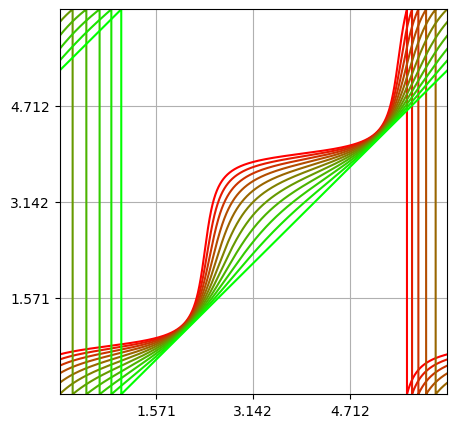

In [43]:
N = 10000
phirange = np.linspace(0,2*np.pi,N)
v = np.array([[np.cos(phi),np.sin(phi)] for phi in phirange])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.set(xlim=(0,2*np.pi),ylim=(0,2*np.pi))
ax.grid()
ax.xaxis.set_major_locator(FixedLocator([np.pi/2,np.pi,3*np.pi/2]))
ax.yaxis.set_major_locator(FixedLocator([np.pi/2,np.pi,3*np.pi/2]))

Kmin = -1
Kmax = 1
Ksetsize = 11
#Kset = np.linspace(-1,1,11)
Kset = np.linspace(Kmin,Kmax,Ksetsize)
for K in Kset:
    B = step_mat(K,1)
    w = v @ B
    plt.plot([arg(v[i]) for i in range(N)],[arg(w[i]) for i in range(N)],c=((K-Kmax)/(Kmin-Kmax),(Kmin-K)/(Kmin-Kmax),0))

plt.show()

На этом графике показано соответствие между $\phi(m)$ и $\phi(m+1)$ при разных $K$: самая зелёная линия это $K=1$, самая красная $K=-1$.

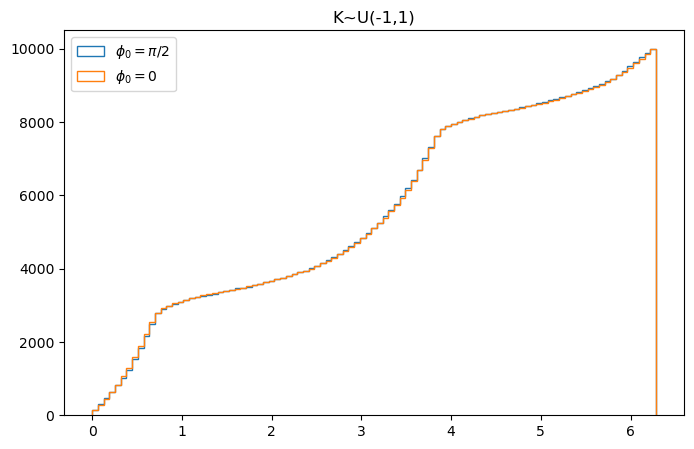

In [49]:
N = 10000

fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot()
#ax.set(xlim = (0,2*np.pi), ylim=(0,N))

phi = np.pi/2
z = np.array([np.cos(phi),np.sin(phi)])
PSI = np.zeros(N)
for i in range(N):
    K = np.random.uniform(-1,1)
    B = step_mat(K,1.0)
    z = z @ B
    PSI[i] = arg(z)
    z = z/np.linalg.norm(z)
ax.hist(PSI,np.linspace(0,2*np.pi,100),cumulative=True,histtype='step',label = '$\phi_0 = \pi/2$')

phi = 0
z = np.array([np.cos(phi),np.sin(phi)])
for i in range(N):
    K = np.random.uniform(-1,1)
    B = step_mat(K,1.0)
    z = z @ B
    PSI[i] = arg(z)
    z = z/np.linalg.norm(z)
ax.hist(PSI,np.linspace(0,2*np.pi,100),cumulative=True,histtype='step',label = '$\phi_0 = 0$')

ax.legend()
ax.title.set_text('K~U(-1,1)')
plt.show()

На это графике видно распределение $\phi(n), n\in[0,1,...,10000]$ при $K~U(-1,1)$ и двух разных стартовых положениях: $\phi(0) = \frac{\pi}{2}$ и $\phi(0) = 0$. Видим, что:
1) распределение не зависит от стартовой позиции
2) плотность распределения концентрируется в областях $\phi\in [0,\frac{\pi}{4}]$ и $\phi\in [\pi,\frac{5\pi}{4}]$, что логично, так как на половине отрезков происходит гиперболическое движение, притягивающее к $\phi = \arctan{\sqrt{-K}} (+\pi)$, а этот угол при $-1\le K < 0$ как раз лежит в $[0,\frac{\pi}{4}]$ $([\pi,\frac{5\pi}{4}])$, в то время на другой половине отрезков эллиптическое движение крутит нас по часовой стрелке и размазывает распределение примерно равномерно. Это как раз хорошо видно на следующем графике

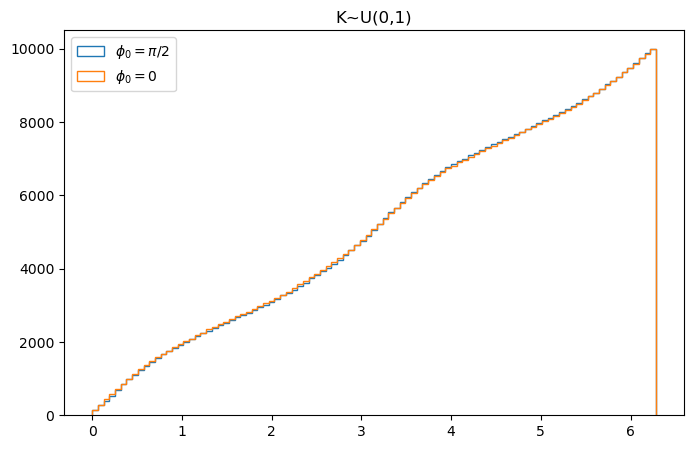

In [54]:
N = 10000

fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot()
#ax.set(xlim = (0,2*np.pi), ylim=(0,N))

phi = np.pi/2
z = np.array([np.cos(phi),np.sin(phi)])
PSI = np.zeros(N)
for i in range(N):
    K = np.random.uniform(0,1)
    B = step_mat(K,1.0)
    z = z @ B
    PSI[i] = arg(z)
    z = z/np.linalg.norm(z)
ax.hist(PSI,np.linspace(0,2*np.pi,100),cumulative=True,histtype='step',label = '$\phi_0 = \pi/2$')

phi = 0
z = np.array([np.cos(phi),np.sin(phi)])
for i in range(N):
    K = np.random.uniform(0,1)
    B = step_mat(K,1.0)
    z = z @ B
    PSI[i] = arg(z)
    z = z/np.linalg.norm(z)
ax.hist(PSI,np.linspace(0,2*np.pi,100),cumulative=True,histtype='step',label = '$\phi_0 = 0$')

ax.legend()
ax.title.set_text('K~U(0,1)')
plt.show()

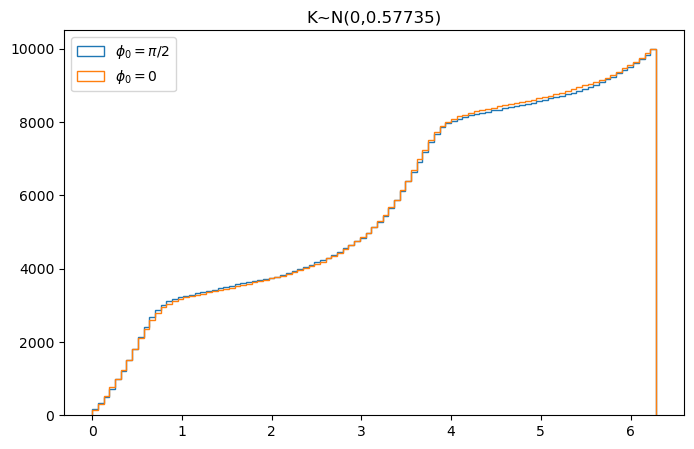

In [57]:
N = 10000

fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot()
#ax.set(xlim = (0,2*np.pi), ylim=(0,N))

phi = np.pi/2
z = np.array([np.cos(phi),np.sin(phi)])
PSI = np.zeros(N)
for i in range(N):
    K = np.random.normal(0,0.57735)
    B = step_mat(K,1.0)
    z = z @ B
    PSI[i] = arg(z)
    z = z/np.linalg.norm(z)
ax.hist(PSI,np.linspace(0,2*np.pi,100),cumulative=True,histtype='step',label = '$\phi_0 = \pi/2$')

phi = 0
z = np.array([np.cos(phi),np.sin(phi)])
for i in range(N):
    K = np.random.normal(0,0.57735)
    B = step_mat(K,1.0)
    z = z @ B
    PSI[i] = arg(z)
    z = z/np.linalg.norm(z)
ax.hist(PSI,np.linspace(0,2*np.pi,100),cumulative=True,histtype='step',label = '$\phi_0 = 0$')

ax.legend()
ax.title.set_text('K~N(0,0.57735)')
plt.show()

##### Дискретизация задачи

Разобъём окружность на $DP$ кусочков $[0,\frac{2\pi}{DP}],...,[2(1-\frac{1}{DP})\pi,2\pi]$, поместим точки в серединах этих кусочков: $\phi_{i} = \frac{\pi}{PD}(1+2i)$. Теперь к каждой точке применим $Pr \circ B(K,1)$ и результат округлим до ближайшей из этих точек.

Для примера возьмём $DP = 18$ и построим таблицу для $K\in [-1,-0.5,0,0.5,1]$

In [16]:
DP = 16
MS = np.linspace(np.pi/DP,(2-1/DP)*np.pi,DP)
K_set = np.linspace(-1.0, 1.0, 5)
table_content_d = {}
for K in K_set:
    col = []
    for i in range(DP):
        col.append(new_sost(DP, i, K, 1.0))
    table_content_d['K = ' + str(K)] = col
df_d = pd.DataFrame(table_content_d, index = list(range(DP)))
df_d

,K = -1.0,K = -0.5,K = 0.0,K = 0.5,K = 1.0
0,1,1,0,15,13
1,1,1,0,0,14
2,2,1,1,0,15
3,2,2,1,1,0
4,2,2,2,2,1
5,3,3,3,3,2
6,8,6,5,4,3
7,9,8,7,5,4
8,9,9,8,7,5
9,9,9,8,8,6


Понятно, что, сделав из окружности набор из $DP$ точек с такими правилами перехода из одной в другую, мы получим марковскую цепь. Возьмём для точности $DP$ побольше, 900. Для каждой точки из множества состояний нашей цепи сгенерируем $EN$ величину $K$, получим матрицу переходных вероятностей.

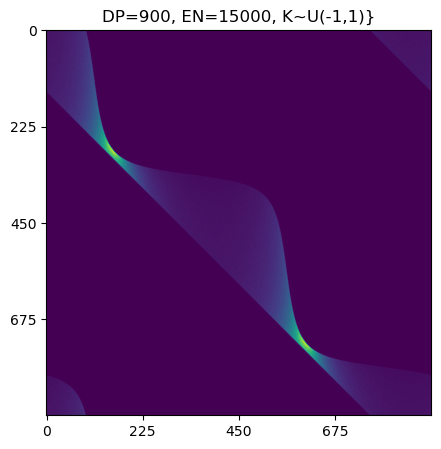

In [59]:
prob_mat = np.load('K_uniform_-1_1_DP_900_EN_15000.npy')
DP = 900
cmap_name = 'viridis'
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
ax.imshow(np.linalg.matrix_power(prob_mat,1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax.grid()
ax.title.set_text('DP=900, EN=15000, K~U(-1,1)}')
plt.show()

Теперь умножаем матрицу саму на себя, получаем матрицу переходов за $n$ шагов.

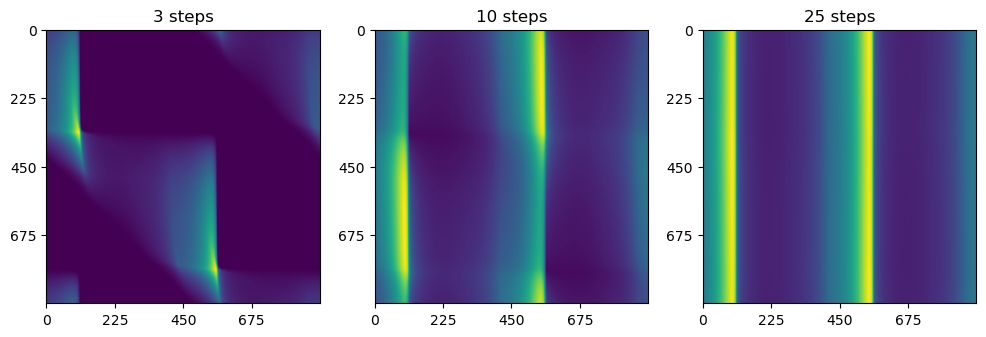

In [60]:
steps_num_1 = 3
steps_num_2 = 10
steps_num_3 = 25

fig = plt.figure(figsize = (12,4))

ax1 = plt.subplot(1,3,1)
ax1.imshow(np.linalg.matrix_power(prob_mat,steps_num_1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax1.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax1.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax1.grid()
ax1.title.set_text(f'{steps_num_1} steps')

ax2 = plt.subplot(1,3,2)
ax2.imshow(np.linalg.matrix_power(prob_mat,steps_num_2), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax2.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax2.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax2.grid()
ax2.title.set_text(f'{steps_num_2} steps')

ax3 = plt.subplot(1,3,3)
ax3.imshow(np.linalg.matrix_power(prob_mat,steps_num_3), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax3.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax3.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax3.grid()
ax3.title.set_text(f'{steps_num_3} steps')

plt.show()

Теперь то же самое можно проделать для нормального распределения

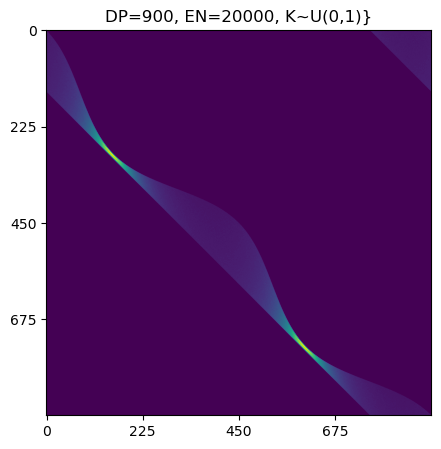

In [63]:
prob_mat = np.load('K_uniform_0_1_DP_900_EN_20000.npy')
DP = 900
cmap_name = 'viridis'
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
ax.imshow(np.linalg.matrix_power(prob_mat,1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax.grid()
ax.title.set_text('DP=900, EN=20000, K~U(0,1)}')
plt.show()

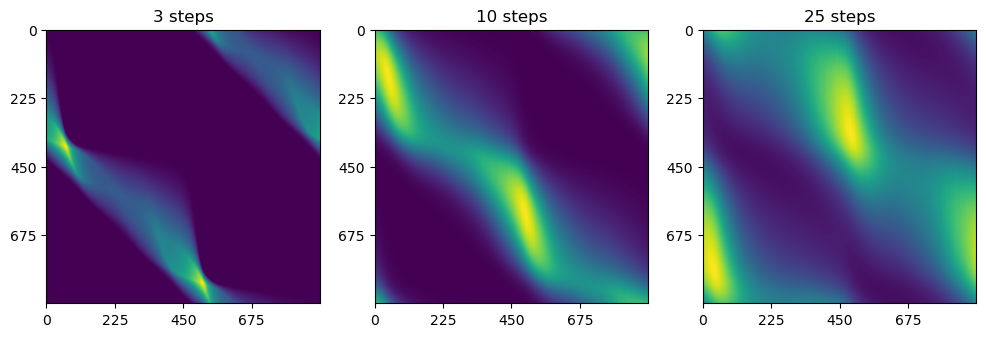

In [64]:
steps_num_1 = 3
steps_num_2 = 10
steps_num_3 = 25

fig = plt.figure(figsize = (12,4))

ax1 = plt.subplot(1,3,1)
ax1.imshow(np.linalg.matrix_power(prob_mat,steps_num_1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax1.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax1.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax1.grid()
ax1.title.set_text(f'{steps_num_1} steps')

ax2 = plt.subplot(1,3,2)
ax2.imshow(np.linalg.matrix_power(prob_mat,steps_num_2), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax2.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax2.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax2.grid()
ax2.title.set_text(f'{steps_num_2} steps')

ax3 = plt.subplot(1,3,3)
ax3.imshow(np.linalg.matrix_power(prob_mat,steps_num_3), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax3.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax3.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax3.grid()
ax3.title.set_text(f'{steps_num_3} steps')

plt.show()

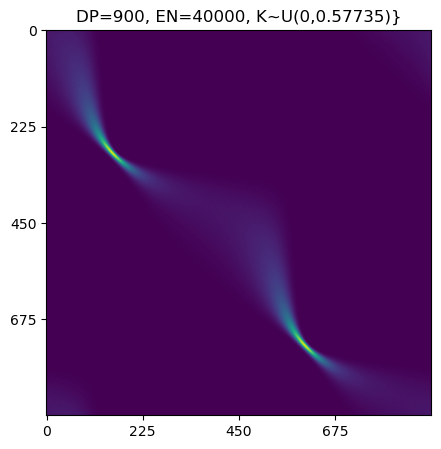

In [61]:
prob_mat = np.load('K_norm_0_0.57735_DP_900_EN_40000.npy')
DP = 900
cmap_name = 'viridis'
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
ax.imshow(np.linalg.matrix_power(prob_mat,1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax.grid()
ax.title.set_text('DP=900, EN=40000, K~N(0,0.57735)}')
plt.show()

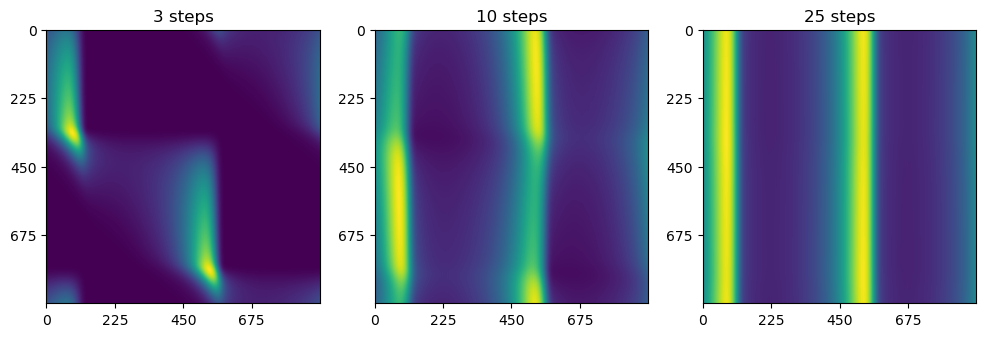

In [62]:
steps_num_1 = 3
steps_num_2 = 10
steps_num_3 = 25

fig = plt.figure(figsize = (12,4))

ax1 = plt.subplot(1,3,1)
ax1.imshow(np.linalg.matrix_power(prob_mat,steps_num_1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax1.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax1.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax1.grid()
ax1.title.set_text(f'{steps_num_1} steps')

ax2 = plt.subplot(1,3,2)
ax2.imshow(np.linalg.matrix_power(prob_mat,steps_num_2), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax2.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax2.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax2.grid()
ax2.title.set_text(f'{steps_num_2} steps')

ax3 = plt.subplot(1,3,3)
ax3.imshow(np.linalg.matrix_power(prob_mat,steps_num_3), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax3.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax3.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax3.grid()
ax3.title.set_text(f'{steps_num_3} steps')

plt.show()

20%
40%
60%
80%


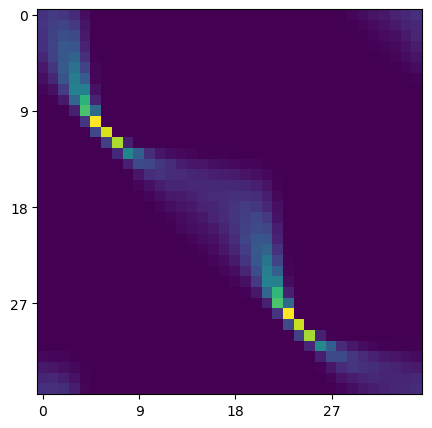

In [18]:
DP = 36
EN = 5000
prob_mat = np.zeros((DP, DP))
for sost in range(DP):
    if sost == int(0.2*DP):
       print('20%')
    if sost == int(0.4*DP):
       print('40%')
    if sost == int(0.6*DP):
       print('60%')
    if sost == int(0.8*DP):
       print('80%')
    for isp in range(EN):
        K = np.random.normal(0,0.57735)
        nsost = new_sost(DP, sost, K, 1.0)
        prob_mat[sost][nsost] += 1
prob_mat /= EN
cmap_name = 'viridis'
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
ax.imshow(np.linalg.matrix_power(prob_mat,1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
plt.show()

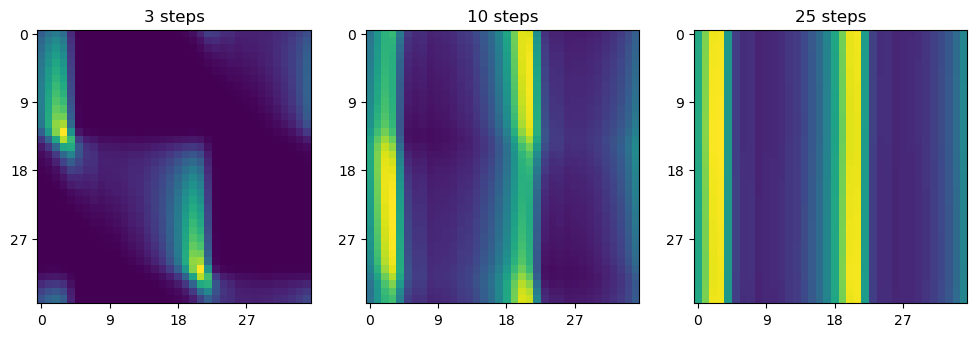

In [19]:
steps_num_1 = 3
steps_num_2 = 10
steps_num_3 = 25

fig = plt.figure(figsize = (12,4))

ax1 = plt.subplot(1,3,1)
ax1.imshow(np.linalg.matrix_power(prob_mat,steps_num_1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax1.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax1.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax1.grid()
ax1.title.set_text(f'{steps_num_1} steps')

ax2 = plt.subplot(1,3,2)
ax2.imshow(np.linalg.matrix_power(prob_mat,steps_num_2), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax2.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax2.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax2.grid()
ax2.title.set_text(f'{steps_num_2} steps')

ax3 = plt.subplot(1,3,3)
ax3.imshow(np.linalg.matrix_power(prob_mat,steps_num_3), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax3.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax3.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax3.grid()
ax3.title.set_text(f'{steps_num_3} steps')

plt.show()